In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from Networks_v2 import Net_Multi,Net_Individual,Masks
from Experiment_v5 import Experiment
from IPython.display import clear_output
from Check import Checkup


 # Reproducibility 

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
# if gpu is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Device: ", device)

G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


# Generate the Dataset

In [3]:
WIDTH = 50
EPOCH = 500
BATCH_SIZE = 32

In [4]:
set_seed(seed=SEED)

experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=BATCH_SIZE,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_val,batch_size=BATCH_SIZE,shuffle = False )
test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=BATCH_SIZE,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

Random seed 2021 has been set.
Test size dataset space torch.Size([249, 6])
Test size dataset weather torch.Size([249, 6])
Test size dataset multi torch.Size([499, 6])
Train size dataset space torch.Size([1750, 6])
Train size dataset weather torch.Size([1750, 6])
Train size dataset multi torch.Size([3494, 6])


y = 0

for x_train, y_train in train_loader:
    if y<2:
        print(y_train)
        print(x_train)
    y+=1

# Initialize the Network

In [11]:

model = Net_Multi(input_dimension=5,nodes_second = 50,nodes_third = 20,nodes_output = 2)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.BCEWithLogitsLoss()
mask = Masks(model)


# Training

Epoch 490, val_loss 0.5492598414421082


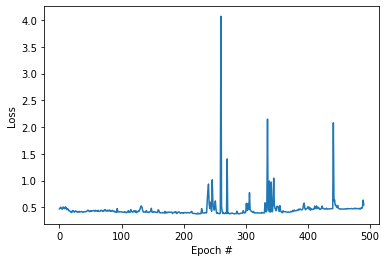

In [12]:

losses = []
val_losses = []
for epoch in range(EPOCH):

    loss = 0
    val_loss = 0 

    for x_batch, y_batch in train_loader:
        
        
        pumpkin_seed= x_batch[0,5]
        x_batch = x_batch[:,0:5].squeeze(0)
            
        optimizer.zero_grad()

        output = model(x_batch)

        output_loss = criterion(output,y_batch.squeeze(0))
        output_loss.backward()
        
                # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        #print("before",model.fc3.weight.grad)
        mask.apply_mask(model,pumpkin_seed)
        #print("after",model.fc3.weight.grad)

                    
                    
        optimizer.step()
        
        
        loss += output_loss.detach().numpy()
    losses.append(loss/len(train_loader))
            
    with torch.no_grad():
        for x_val, y_val in val_loader:
            model.eval() # not useful for now
            x_val = x_val[:,0:5].squeeze(0)
            yhat = model(x_val)
            val_loss += criterion(yhat,y_val.squeeze(0))
        val_losses.append(val_loss.item()/len(val_loader))


    if np.mod(epoch,10)==0: 
        clear_output()
        print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(val_losses)), val_losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch #')
        plt.show()
            



# Accuracy score

In [13]:
checkUP = Checkup() 
EPSILON = 0.3
checkUP.Display_Score(model,test_loader, EPSILON,False,True)

Score final :  65.53106212424849


# Number of nodes comparison

In [59]:
REPETITION = 10
EPOCH = 200
Liste_nodes = [[20,20],[30,20],[40,20],[50,20],[50,30]]
Total_val_loss = [[[] for i in range(REPETITION)] for j in range(len(Liste_nodes))]


[[], [], [], [], [], [], [], [], [], []]


Epoch 190, val_loss 0.4977600872516632


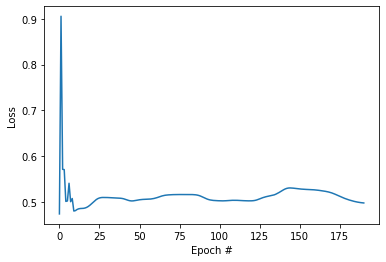

In [61]:
k = 0
for nodes_1,nodes_2 in Liste_nodes:
    print(nodes_1,nodes_2)
    
    for repetition in range(REPETITION):

        model = Net_Multi(input_dimension=5,nodes_second =nodes_1,nodes_third = nodes_2,nodes_output = 2)    
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        criterion = nn.BCEWithLogitsLoss()
        mask = Masks(model)


        losses = []
        val_losses = []
        for epoch in range(EPOCH):

            loss = 0
            val_loss = 0 

            for x_batch, y_batch in train_loader:


                pumpkin_seed= x_batch[0,5]
                x_batch = x_batch[:,0:5].squeeze(0)

                optimizer.zero_grad()

                output = model(x_batch)

                output_loss = criterion(output,y_batch.squeeze(0))
                output_loss.backward()
     
                mask.apply_mask(model,pumpkin_seed)
               
                optimizer.step()


                loss += output_loss.detach().numpy()
            losses.append(loss/len(train_loader))

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    model.eval() # not useful for now
                    x_val = x_val[:,0:5].squeeze(0)
                    yhat = model(x_val)
                    val_loss += criterion(yhat,y_val.squeeze(0))
                val_losses.append(val_loss.item()/len(val_loader))


            if np.mod(epoch,10)==0: 
                clear_output()
                print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
                fig = plt.figure()
                ax = fig.add_subplot(111)
                plt.plot(np.arange(len(val_losses)), val_losses)
                plt.ylabel('Loss')
                plt.xlabel('Epoch #')
                plt.show()
        
        Total_val_loss[k][repetition] =  val_losses
    k+=1





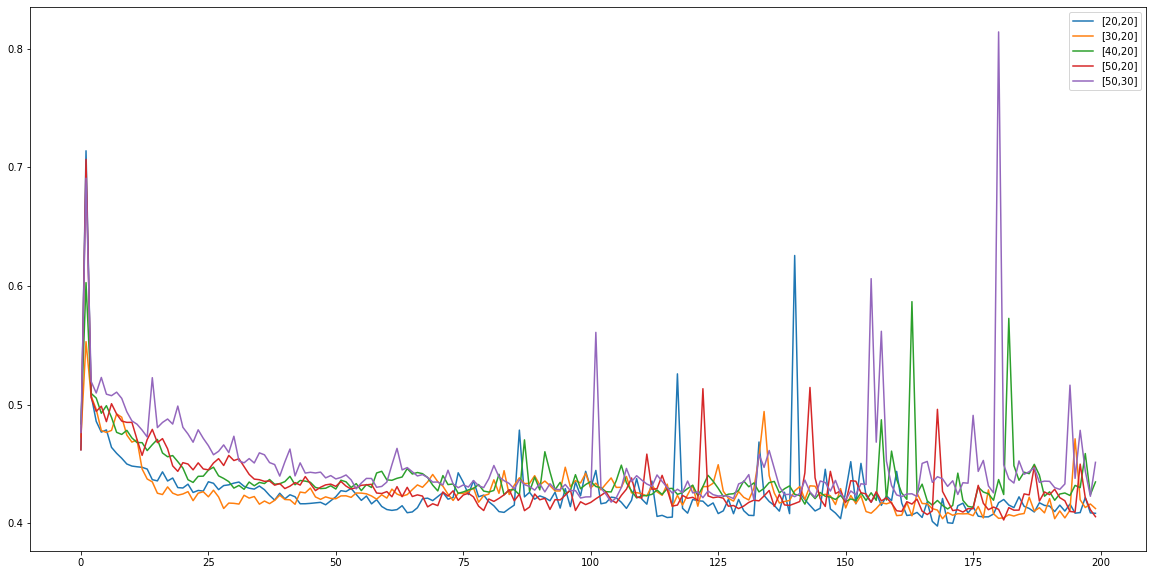

In [62]:
L_color = ["b","r","g","c","m"]
L_label = ["[20,20]","[30,20]","[40,20]","[50,20]","[50,30]"]

Mean_total_val_loss = np.mean(Total_val_loss,axis = 1)

plt.figure(figsize=(20,10))
for k in range(len(Liste_nodes)):
    plt.plot(np.arange(len(val_losses)), Mean_total_val_loss[k], label = L_label[k] )


plt.legend()